# EngDeu Neural Machine Translation Project Notebook
_August 2025_

### Package Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union
from statsmodels.formula.api import ols
import util, model_eval
from termcolor import colored as c

### Visualize Traning Curves

In [2]:
def read_training_history(model_name: str, src_lang: str, tgt_lang: str) -> Tuple[pd.Series]:
    """
    Helper function for reading in the training history for a given model.
    Returns the in-sample perplexity of the model logged while training and also the
    validation set perplexity of the model logged while training as a tuple of pd.Series.
    
    :param model_name: Name of the input model e.g. LSTM_Att.
    :param: src_lang: The source language i.e. either 'eng' or 'deu'.
    :param: tgt_lang: The target language i.e. either 'eng' or 'deu'.
    :returns: A tuple of perplexity scores obtained during training.
    """
    translation_name = f"{src_lang.capitalize()}{tgt_lang.capitalize()}"
    save_dir = f"saved_models/{model_name}/{translation_name}"
    training_hist = pd.read_csv(os.path.join(save_dir, "training_ppl.csv"), index_col=0).iloc[:, 0]
    validation_hist = pd.read_csv(os.path.join(save_dir, "validation_ppl.csv"), index_col=0).iloc[:, 0]
    return training_hist, validation_hist

In [3]:
def plot_training_history(model_name: str, src_lang: str, tgt_lang: str, ax=None) -> None:
    """
    Helper function for plotting the training history for a given model. Plots the in-sample and
    validation set log perplexity values vs training iteration.
    
    :param model_name: Name of the input model e.g. LSTM_Att, used for display in the title.
    :param src_lang: The source language.
    :param tgt_lang: The target language.
    :param ax: An optional plotting axis which can be provided to specify where the make the plot.
    :returns: None, plots the training history.
    """
    training_hist, validation_hist = read_training_history(model_name, src_lang, tgt_lang)
    translation_name = f"{src_lang.capitalize()}{tgt_lang.capitalize()}"
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(training_hist, label="Training")
    ax.plot(validation_hist, label="Validation")
    ax.set_yscale("log")
    ax.set_title(f"{model_name} {translation_name} Training History")
    ax.set_ylabel("log(perplexity)");ax.set_xlabel("Training Iteration")
    ax.grid(color="lightgray", zorder=-3)
    ax.legend()

### Plot the Training History Curves of all the models

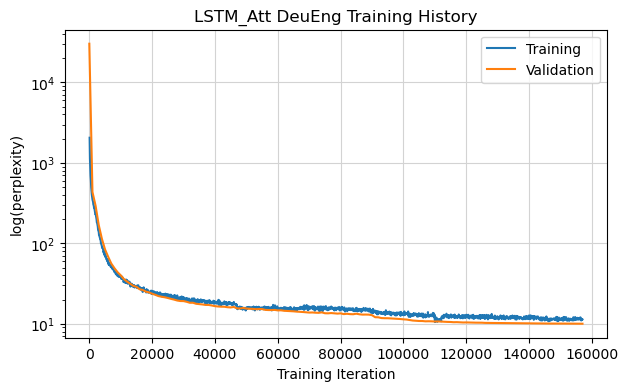

In [4]:
# The first "main" model
model_name = "LSTM_Att"
plot_training_history(model_name, "deu", "eng")

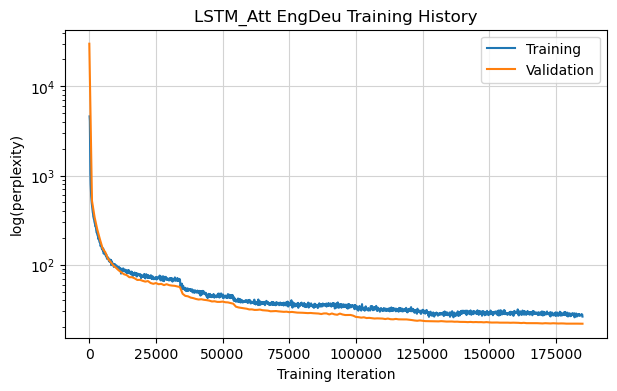

In [5]:
# The second model, used pre-trained word embeddings to speed up training
model_name = "LSTM_Att"
plot_training_history(model_name, "eng", "deu")

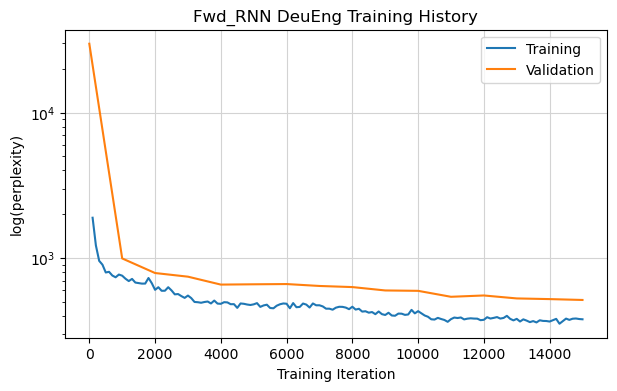

In [6]:
# Used the pre-trained word-embeddings to train
plot_training_history("Fwd_RNN", "deu", "eng")

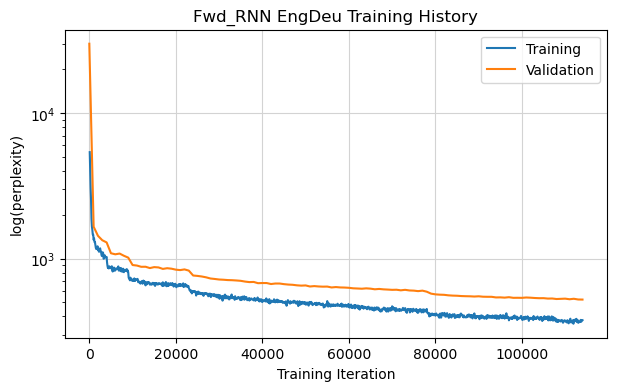

In [7]:
# Used the pre-trained word-embeddings to train
plot_training_history("Fwd_RNN", "eng", "deu")

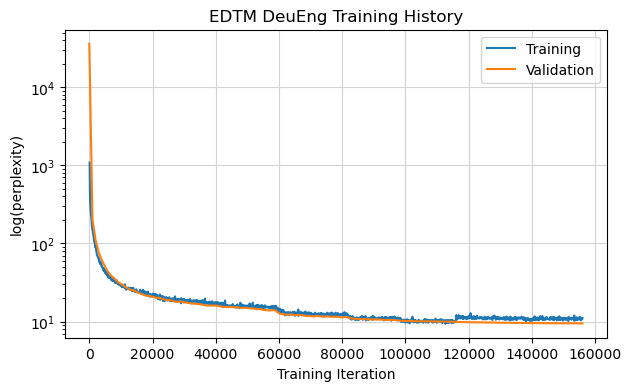

In [8]:
plot_training_history("EDTM", "deu", "eng")

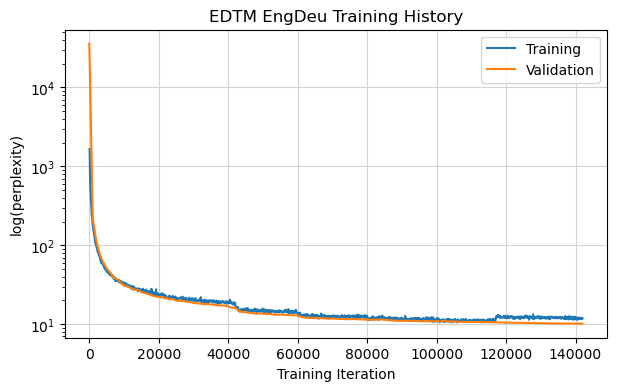

In [9]:
plot_training_history("EDTM", "eng", "deu") # Used the pre-trained word-embeddings to train

### Some Sentence Length EDA

In [5]:
def summarize_sentence_length_dist(dataset_name: str, use_subword_tokens: bool = False) -> None:    
    print(f"dataset_name: {dataset_name}")
    
    if use_subword_tokens:
        eng_data = util.read_corpus("eng", dataset_name, False, True)
        deu_data = util.read_corpus("deu", dataset_name, False, True)

        # Count the lengths of each tokenized sentence from each
        eng_lengths = pd.Series([len(x) for x in eng_data])
        deu_lengths = pd.Series([len(x) for x in deu_data])

        title_str = "Word"
        
    else:
        eng_data = util.read_corpus("eng", dataset_name, False, False)
        deu_data = util.read_corpus("deu", dataset_name, False, False)

        # Count the lengths of each tokenized sentence from each
        eng_lengths = pd.Series([len(x.split()) for x in eng_data])
        deu_lengths = pd.Series([len(x.split()) for x in deu_data])      

        title_str = "Sub-Word"

    len_df = pd.DataFrame({"eng": eng_lengths, "deu": deu_lengths})
    corr = len_df.corr().iloc[0, 1]
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(eng_lengths, deu_lengths, zorder=3)
    ax.set_xlabel("Eng Tokens");ax.set_ylabel("Deu Tokens")
    ax.set_title(f"N {title_str} Tokens by Sentence: {dataset_name} (corr={corr:.2f})")
    ax.grid(color="lightgray", zorder=-3)
    
    bins = 50
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.hist(eng_lengths, alpha=0.5, label="eng", bins=bins, density=True)
    ax.hist(deu_lengths, alpha=0.5, label="deu", bins=bins, density=True)
    ax.set_title(f"Density Distribution of {title_str} Tokens per Sentence")
    ax.legend();plt.show()
    
    reg_model = ols("deu ~ eng - 1", len_df).fit(cov_type="HC2")
    display(reg_model.summary())
    display(len_df.describe()) # Summary stats for each
    
    # Examine the longest sentences
    idx = len_df.loc[len_df["eng"] == len_df.max()["eng"]].index[0]
    print(c("Longest English Sentence:", "magenta"))
    print(eng_data[idx])
    print(c("Accompanying German Translation:", "red"))
    print(deu_data[idx])

    idx = len_df.loc[len_df["deu"] == len_df.max()["deu"]].index[0]
    print(c("\nLongest German Sentence:", "red"))
    print(deu_data[idx])
    print(c("Accompanying English Translation:", "magenta"))
    print(eng_data[idx])

    # Examine the shortest sentences
    idx = len_df.loc[len_df["eng"] == len_df.min()["eng"]].index[0]
    print(c("\nShortest English Sentence:", "magenta"))
    print(eng_data[idx])
    print(c("Accompanying German Translation:", "red"))
    print(deu_data[idx])

    idx = len_df.loc[len_df["deu"] == len_df.min()["deu"]].index[0]
    print(c("\nShortest German Sentence:", "red"))
    print(deu_data[idx])
    print(c("Accompanying English Translation:", "magenta"))
    print(eng_data[idx])

dataset_name: train_debug


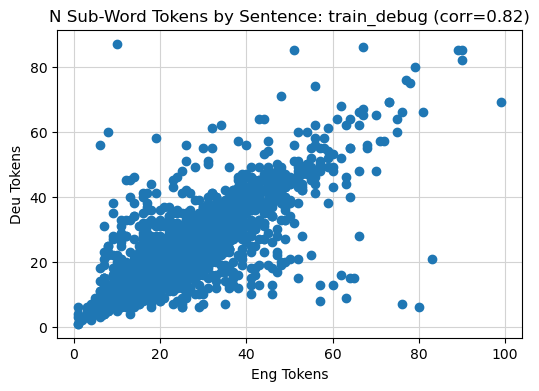

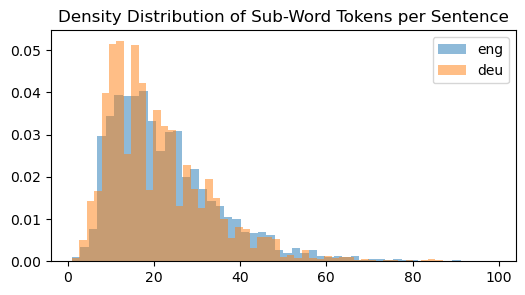

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    deu   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                          1.345e+04
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                        0.00
Time:                        20:52:52   Log-Likelihood:                         -10159.
No. Observations:                3000   AIC:                                  2.032e+04
Df Residuals:                    2999   BIC:                                  2.033e+04
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eng            0.8866      0.008    115.990      0.000       0.872       0.902
==============================================================================
Omnibus:                      713.632   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39141.974
Skew:                          -0.104   Prob(JB):                         0.00
Kurtosis:                      20.694   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

,eng,deu
count,3000.000000,3000.000000
mean,22.675000,21.003000
std,12.899335,12.042286
min,1.000000,1.000000
25%,13.000000,12.000000
50%,20.000000,18.000000
75%,29.000000,27.000000
max,99.000000,87.000000


Longest English Sentence:
France learntec Viet Nam biology Kambodscha Fun Freiwilligenagentur MehrWERT dvd Ulis Galerie - Dessau Art Köln Joomla! arbeit Internship Exildomizil dprg party Web 2.0 travelling bloggen LAGFA Wolfen University Schule Ulis Galerie - Malta 08 moblog 22c3 video2brain Einsatzstellenüberprüfung Musik Second Life los Music bloghouse.org Familientag 2006 Paris Ausbildung zur freiwilligen Seniorenbegleitung wellcome vielfalt Fitou House san francisco cambodia Politik Nha Trang work MZ-Zitat murge yourself Vin Stadt video eu-project Familienbündnis fimidi.com das ist london Ulis Galerie - Reha 07 Ulis Galerie - Blumen Fotos Seniorenbegleiter mambo USA-Reise Drupalcon Weihnachten Mitteldeutsche Zeitung vietnam mehrgenerationenhaus aktuell Perpignan FA MehrWERT Joomla!
Accompanying German Translation:
Fun bloghouse.org Paris Drupal Ulis Galerie - Malta 08 LAGFA Drupalcon Musik work Wolfen Music Filous Blog Familientag 2006 aktuell Kambodscha los Viet Nam vietnam Weihna

In [27]:
summarize_sentence_length_dist("train_debug", False)

dataset_name: validation


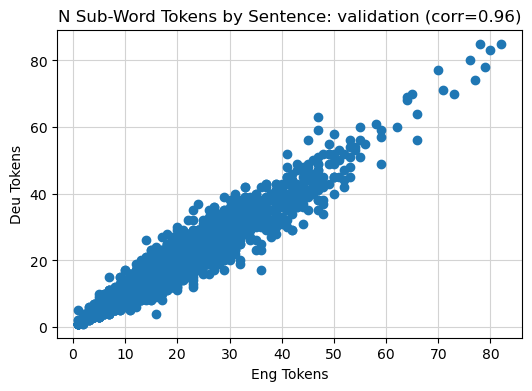

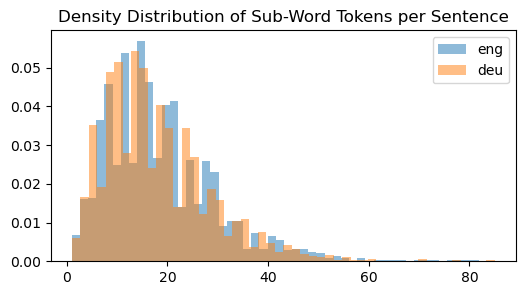

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    deu   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          7.556e+04
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                        0.00
Time:                        20:52:59   Log-Likelihood:                         -7701.6
No. Observations:                3000   AIC:                                  1.541e+04
Df Residuals:                    2999   BIC:                                  1.541e+04
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eng            0.9688      0.004    274.890      0.000       0.962       0.976
==============================================================================
Omnibus:                      140.247   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.722
Skew:                           0.038   Prob(JB):                    5.55e-106
Kurtosis:                       4.968   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

,eng,deu
count,3000.000000,3000.000000
mean,18.696333,18.234000
std,10.998293,10.913216
min,1.000000,1.000000
25%,11.000000,10.000000
50%,17.000000,16.000000
75%,24.000000,24.000000
max,82.000000,85.000000


Longest English Sentence:
Israel's current prime minister, Netanyahu 'the hawk', is a typical example of a fascist politician, loyal to the international bankers, who does everything to instigate war with Iran, which would, due to its membership in the Shanghai Cooperation Organisation (China, India, Russia, Pakistan, ...) lead to a greater threat of global conflict, and through its control of the Hormuz Strait, where 20% of the world's oil must sail (the channel is only 2 miles wide), to the destruction of the world's economy.
Accompanying German Translation:
Der derzeitige Premierminister Israels, der Falke Netanjahu, ist ein typisches Beispiel eines faschismusanfälligen, den internationalen Bankern loyal ergebenen Politikers, der alles dafür tut, um einen Krieg mit dem Iran zu entfachen, welcher sich angesichts der Mitgliedschaft Irans in der Schanghaier Organisation für Zusammenarbeit (China, Indien, Russland, Pakistan...), rasch zu einem globalen Konflikt ausweiten könnte, und bei

In [28]:
summarize_sentence_length_dist("validation", False)

dataset_name: test


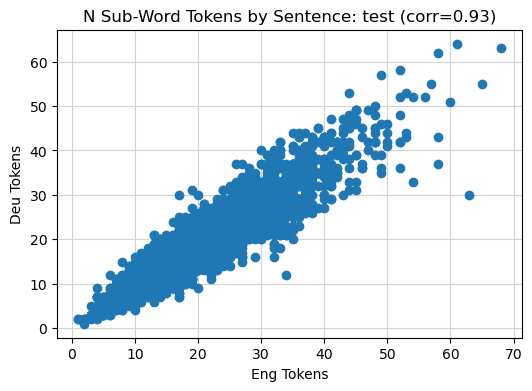

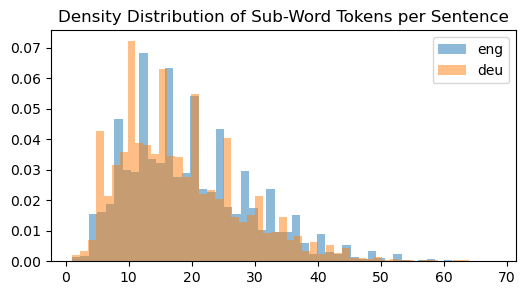

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    deu   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          5.587e+04
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                        0.00
Time:                        20:53:03   Log-Likelihood:                         -8013.7
No. Observations:                3003   AIC:                                  1.603e+04
Df Residuals:                    3002   BIC:                                  1.604e+04
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eng            0.9192      0.004    236.377      0.000       0.912       0.927
==============================================================================
Omnibus:                      216.539   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              968.070
Skew:                          -0.186   Prob(JB):                    6.11e-211
Kurtosis:                       5.757   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

,eng,deu
count,3003.000000,3003.000000
mean,19.755245,18.270063
std,9.923544,9.555964
min,1.000000,1.000000
25%,12.000000,11.000000
50%,18.000000,17.000000
75%,26.000000,24.000000
max,68.000000,64.000000


Longest English Sentence:
Speaking to an open government conference in London via video link, Mr Kerry said: "There is no question that the President and I and others in government have actually learned of some things that had been happening on an automatic pilot because the ability has been there, going back to World War Two and to the very difficult years of the Cold War, and then, of course, 9/11."
Accompanying German Translation:
Bei einer per Videoverbindung übertragenen Rede auf der Open Government-Konferenz in London sagte Kerry: „Ganz ohne Frage haben der Präsident und ich sowie andere in der Regierung von einigen Dingen erfahren, die quasi per Autopilot abgelaufen sind, einfach weil die Fähigkeit dazu bestand, was noch auf den Zweiten Weltkrieg und die schwierigen Jahre des Kalten Krieges sowie natürlich auf den 11. September zurückgeht.“

Longest German Sentence:
Es gibt tatsächlich 1.200 offiziell anerkannte Spukhäuser in den Vereinigten Staaten, die 500 Millionen Dollar Erl

In [29]:
summarize_sentence_length_dist("test", False)

### Examine the ratio of word lengths vs one another

In [45]:
dataset_name = "train_debug"
eng_data = util.read_corpus("eng", dataset_name, False, False)
deu_data = util.read_corpus("deu", dataset_name, False, False)

# Count the lengths of each tokenized sentence from each
eng_lengths = pd.Series([len(x.split()) for x in eng_data])
deu_lengths = pd.Series([len(x.split()) for x in deu_data])  
length_ratio = np.log(eng_lengths) - np.log(deu_lengths)
print(length_ratio.min(), length_ratio.max())
# Some remain that are extreme, but this is because they fall within the short-sentence allowance

-0.7472144018302207 0.7472144018302207


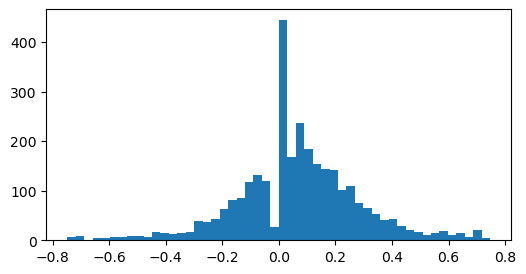

In [46]:
plt.figure(figsize=(6, 3))
plt.hist(length_ratio, bins=50);plt.show()

Something like +/- 0.75 seems to be the best here, for very short sentences, we can probably extend that a little.

In [47]:
# Examine the shortest english relative to german
idx = np.argmin(length_ratio)
print(c(f"\nShortest English Sentence (as a % of the German = {length_ratio[idx]:.2f}):", "magenta"))
print(eng_data[idx])
print(c("Accompanying German Translation:", "red"))
print(deu_data[idx])

idx = np.argmax(length_ratio)
print(c(f"\nShortest German Sentence (as a % of the Englush = {length_ratio[idx]:.2f}):", "red"))
print(deu_data[idx])
print(c("Accompanying English Translation:", "magenta"))
print(eng_data[idx])


Shortest English Sentence (as a % of the German = -0.75):
Helene Hørlyck is a highly acclaimed classical crossover vocalist.
Accompanying German Translation:
Die dänische Sängerin Helene Horlyck gilt Kennern in ganz Europa als eine der interessantesten Vokalistinnen im Bereich des Pop/Klassik-Crossover.

Shortest German Sentence (as a % of the Englush = 0.75):
It is in a perfect location to see Florence.
Accompanying English Translation:
Service was Excellent and staff very helpful and friendly. The location is ideal beng close to all interesting sites.


dataset_name: train_debug


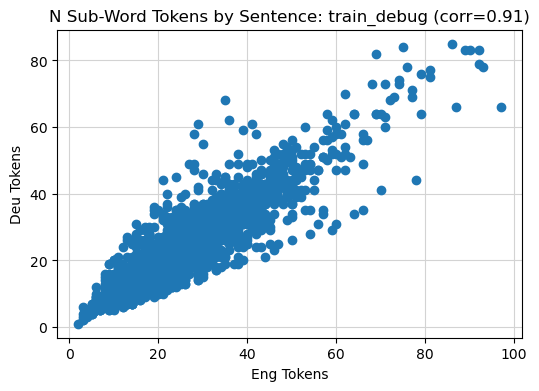

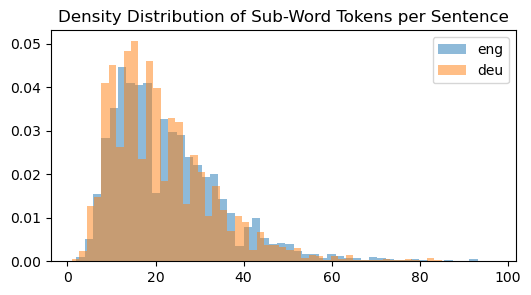

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    deu   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          3.661e+04
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                        0.00
Time:                        21:40:54   Log-Likelihood:                         -9066.6
No. Observations:                3000   AIC:                                  1.814e+04
Df Residuals:                    2999   BIC:                                  1.814e+04
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eng            0.9198      0.005    191.345      0.000       0.910       0.929
==============================================================================
Omnibus:                      453.624   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5012.710
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                       9.296   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

,eng,deu
count,3000.000000,3000.000000
mean,22.931000,21.511667
std,12.747905,12.012520
min,2.000000,1.000000
25%,14.000000,13.000000
50%,20.000000,19.000000
75%,29.250000,27.000000
max,97.000000,85.000000


Longest English Sentence:
These are not governed by the Community's laws and regulations, the organs of the European Union play no part in them, and if you want to know what the obligations covering movements of this kind are I must refer you to the obligations undertaken under the International Atomic Energy Agency and the IMO, the International Maritime Organization. Within these bodies individual EU Member States - I cannot recall off the top of my head which they are, I hope they will forgive me - are required to meet their own treaty obligations vis à vis third countries.
Accompanying German Translation:
Und wenn Sie fragen, welche Verpflichtungen mit dieser Art von Transporten verbunden sind, muß ich Sie auf die Bestimmungen im Rahmen der internationalen Atomenergiebehörde verweisen und die der IMO, der Internationalen Schiffahrtsorganisation, die einzelnen Mitgliedstaaten die Einhaltung ihrer vertraglichen Verpflichtungen gegenüber Drittländern vorschreiben - ich kann mich jetzt

In [48]:
summarize_sentence_length_dist("train_debug", False)

# Attention Score Visualizations

In [21]:
from models import all_models
import util
import numpy as np
import pandas as pd

In [22]:
model = all_models.load_model("LSTM_Att", "deu", 'eng')

src_sentences = ["Was haben Sie am Wochenende gemacht?", 'Wo hast du diese schicke Jacke gekauft?',
                 "Ich bin in Frankreich gebornen und ich bin in einer Kleinstadt aufgewachsen."]

src_sentences = util.tokenize_sentences(src_sentences, "deu")
mt = model.translate(src_sentences, beam_size=5, k_pct=0.1, max_decode_lengths=None, tokenized=True)

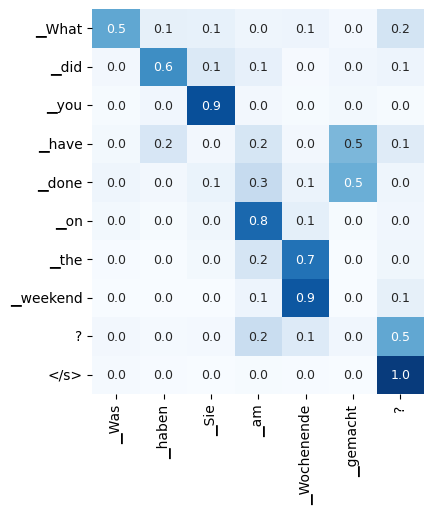

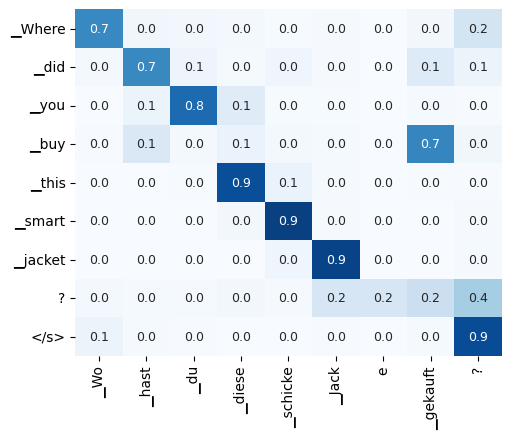

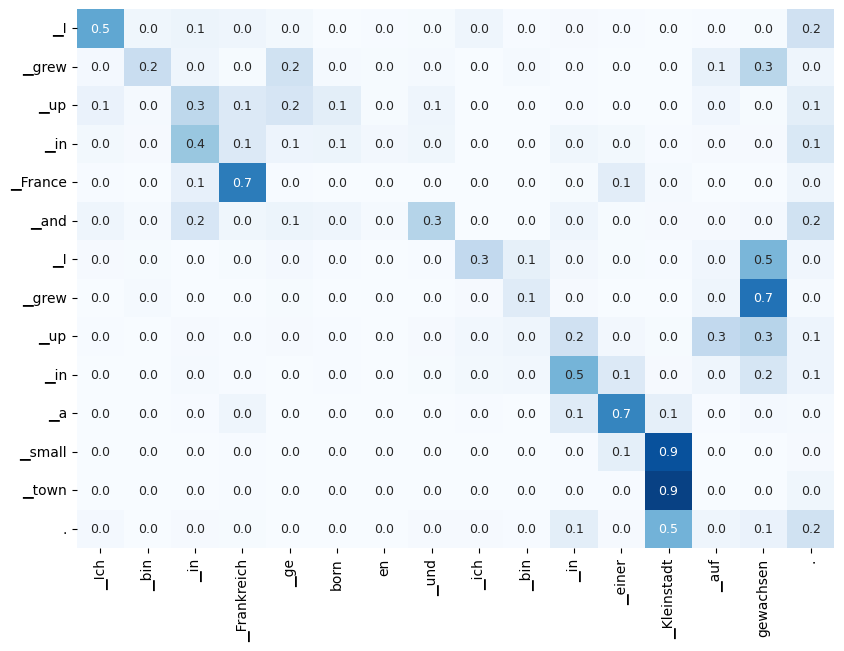

In [17]:
for h in mt:
    util.plot_heatmap(h[2], min_val=0, max_val=1, cmap="Blues")

### Also show this for English to German translations

In [26]:
model = all_models.load_model("LSTM_Att", "eng", 'deu')

src_sentences = ["Where is the bank?", "What did you say?", "Good day.", "I am nineteen years old.",
                 "Are you a doctor?", "How's it going?", "What time is it?", "How can I help you?",
                 "What did you do on the weekend?", "The big beautiful blue sky is so magestic, don't think?"]

src_sentences = util.tokenize_sentences(src_sentences, "eng")
mt = model.translate(src_sentences, beam_size=5, k_pct=0.1, max_decode_lengths=None, tokenized=True)

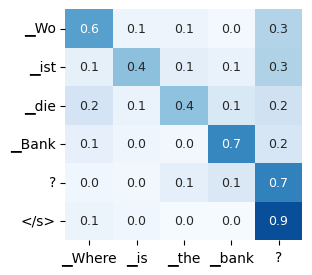

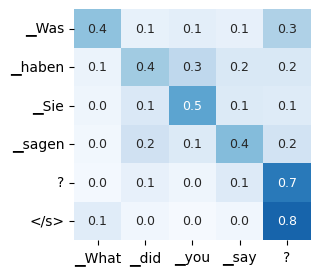

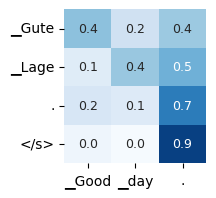

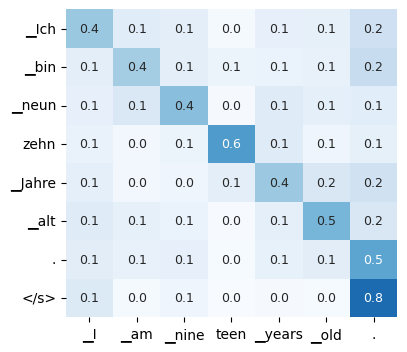

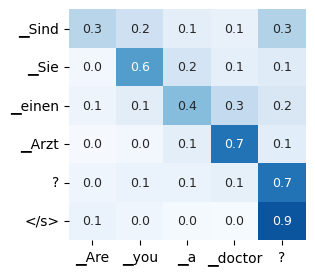

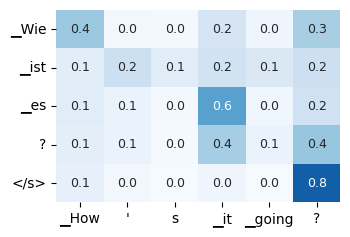

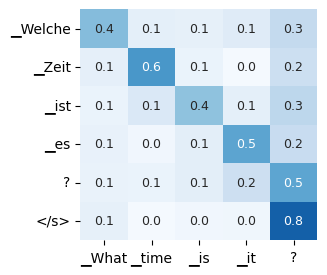

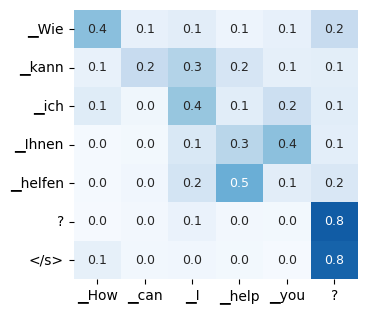

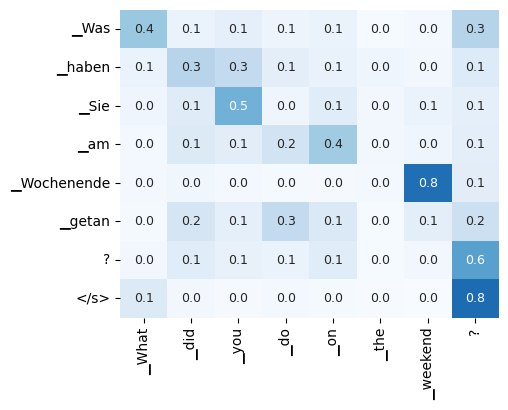

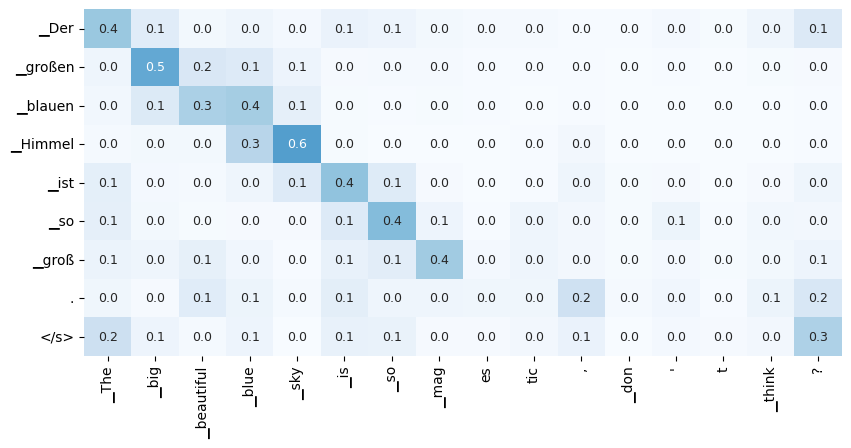

In [27]:
for h in mt:
    util.plot_heatmap(h[2], min_val=0, max_val=1, cmap="Blues")

### Other Model Testing

In [30]:
model = all_models.load_model("EDTM", "eng", 'deu')

src_sentences = ["Where is the bank?", "What did you say?", "Good day.", "I am nineteen years old.",
                 "Are you a doctor?", "How's it going?", "What time is it?", "How can I help you?",
                 "What did you do on the weekend?", "The big beautiful blue sky is so magestic, don't think?"]

mt = model.translate(src_sentences, beam_size=5, k_pct=0.1, max_decode_lengths=None, tokenized=False)

In [31]:
mt

[['Wo ist die Bank?', tensor(0.9554)],
 ['Was haben Sie gesagt?', tensor(0.8208)],
 ['Guter Tag.', tensor(3.2863)],
 ['Ich bin neunzehn Jahre alt.', tensor(0.4594)],
 ['Sind Sie Arzt?', tensor(1.2355)],
 ['Wie geht es?', tensor(3.3583)],
 ['Welche Zeit ist es?', tensor(2.5482)],
 ['Wie kann ich Ihnen helfen?', tensor(0.6506)],
 ['Was haben Sie am Wochenende getan?', tensor(1.2540)],
 ['Der große blaue Himmel ist so magisch, denken Sie nicht?', tensor(6.1259)]]

## Examine how many tokens per sentence are there generally in each data set, plot the distributions

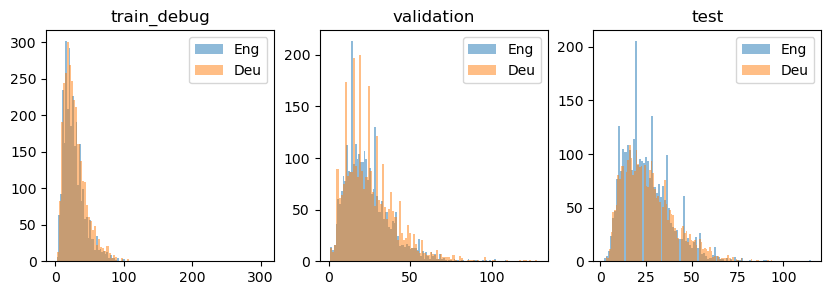

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

smry = pd.DataFrame(dtype=float)

for i, data_set_name in enumerate(["train_debug", "validation", "test"]):
    ax = axes[i]
    eng_data = util.read_corpus("eng", data_set_name, is_tgt=False)
    deu_data = util.read_corpus("deu", data_set_name, is_tgt=False)
    eng_data_len = pd.Series([len(x) for x in eng_data])
    deu_data_len = pd.Series([len(x) for x in deu_data])
    deu_descr = deu_data_len.describe()
    eng_descr = eng_data_len.describe()
    
    smry.loc[f"{data_set_name}_deu", deu_descr.index] = deu_descr.values
    smry.loc[f"{data_set_name}_eng", eng_descr.index] = eng_descr.values
    
    ax.hist(eng_data_len, alpha=0.5, bins=100, label="Eng")
    ax.hist(deu_data_len, alpha=0.5, bins=100, label="Deu")
    ax.set_title(data_set_name);ax.legend()

plt.show()

In [56]:
smry

,count,mean,std,min,25%,50%,75%,max
train_debug_deu,3000.0,28.978333,17.165705,2.0,17.0,25.0,37.0,305.0
train_debug_eng,3000.0,27.729667,16.305333,2.0,17.0,24.0,35.0,253.0
validation_deu,2996.0,25.779372,15.735662,1.0,14.0,23.0,34.0,128.0
validation_eng,2996.0,23.955941,14.052753,1.0,14.0,21.0,31.0,109.0
test_deu,3003.0,26.729937,14.043617,3.0,16.0,24.0,35.0,94.0
test_eng,3003.0,25.57043,13.020532,2.0,16.0,23.0,33.0,115.0


**Conclusion**: Almost none of these sentences are that... we should probably set a cap at 200 tokens and leave it at that.

In [72]:
eng_data = util.read_corpus("deu", "train_debug", is_tgt=False)
eng_data_len = pd.Series([len(x) for x in eng_data])

In [73]:
longest_eng_sentence = eng_data[eng_data_len.sort_values().index[-1]]

In [74]:
util.tokens_to_str(longest_eng_sentence)

'----------------------------------------------------------------------- ID: OSA-2008-01 Datum: 2008-03-31 Titel: Schwachstellen in der OTRS SOAP Schnittstelle erlaubt remote Zugriff ohne gueltigen SOAP Benutzer Einstufung: Kritisch Produkt: OTRS 2.2.x, OTRS 2.1.x Behoben in: OTRS 2.2.6, OTRS 2.1.8 Nicht Betroffen: OTRS 2.0.x, OTRS 1.x.x URL: http://otrs.org/advisory/OSA-2008-01-de/ CVE: CVE-2008-1515 ---------------------------------------------------------------------- Dieses Advisory adressiert eine Sicherheitsluecke in der OTRS SOAP Schnittstelle. Die SOAP Autentifizierung erlaubt remote Zugriff ohne gueltigen SOAP Benutzer.'

## Examine how correlated the tokens per sentence are for the machine translations and the gold-standards ys
This will help show us qualitatively how well the machine translations match up to the actual translations provided as labeled data in each data set. We expect to see a strong positive correlation i.e. our machine translation length should be generally similar to that of the data set target translation provided.

This will also help us identify max decode length problems if any still persist i.e. we should expect to see the output translations correlating well to the tgt versions and they should grow in size along side them.

In [5]:
from models import all_models

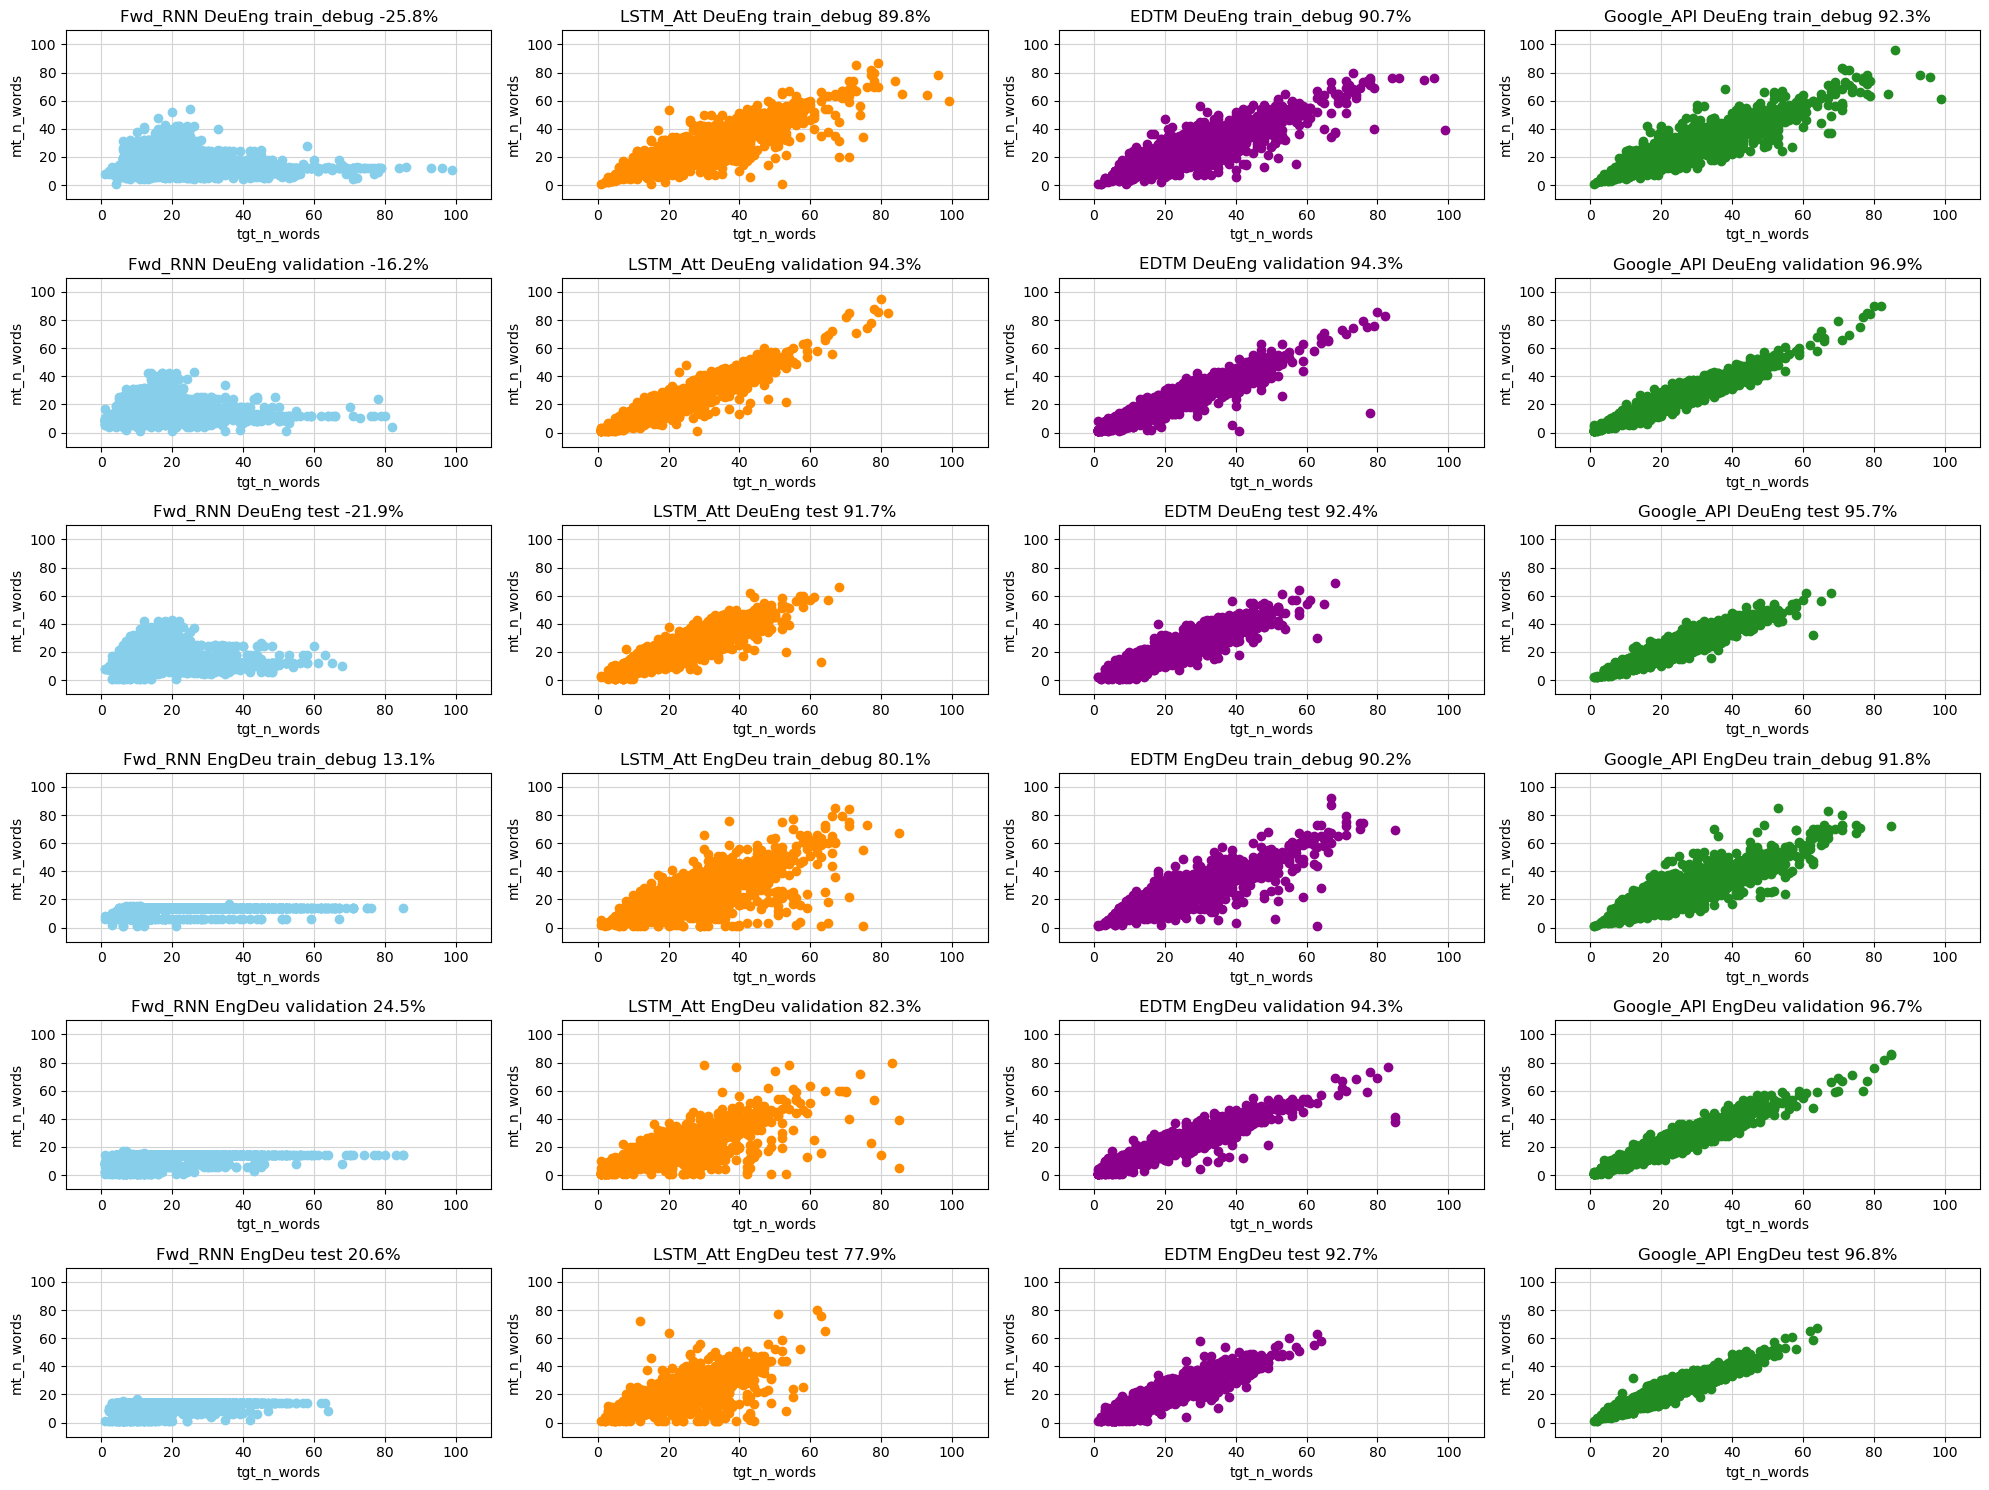

In [23]:
fig, axes = plt.subplots(6, 4, figsize=(20, 15))
axes = axes.reshape(-1)
model_colors = {"Fwd_RNN": "skyblue", "LSTM_Att": "darkorange", "EDTM": "darkmagenta", "Google_API": "forestgreen"}

i = 0
for lang_pair in ["DeuEng", "EngDeu"]:
    for data_set_name in ["train_debug", "validation", "test"]:
        for model_name in all_models.MODELS:
            mt_df = pd.read_csv(f"model_pred/{lang_pair}/{model_name}/{data_set_name}.csv")
            ax = axes[i]
            # Count words by counting the number of spaces, add 1 since there are (n-1) spaces between n words
            plot_df = pd.DataFrame({"tgt_n_words": mt_df["tgt"].str.count(" ") + 1, "mt_n_words": mt_df["mt"].str.count(" ") + 1})
            ax.scatter(plot_df["tgt_n_words"], plot_df["mt_n_words"], zorder=3, color=model_colors[model_name])
            ax.set_title(f"{model_name} {lang_pair} {data_set_name} {plot_df.corr().iloc[0, 1]:.1%}")
            ax.set_xlabel("tgt_n_words");ax.set_ylabel("mt_n_words")
            ax.set_xlim(-10, 110);ax.set_ylim(-10, 110)
            ax.grid(color="lightgray", zorder=-3)
            i += 1

plt.tight_layout();plt.show()

### Repeat but this time on a basis of src_n_words vs mt_n_words

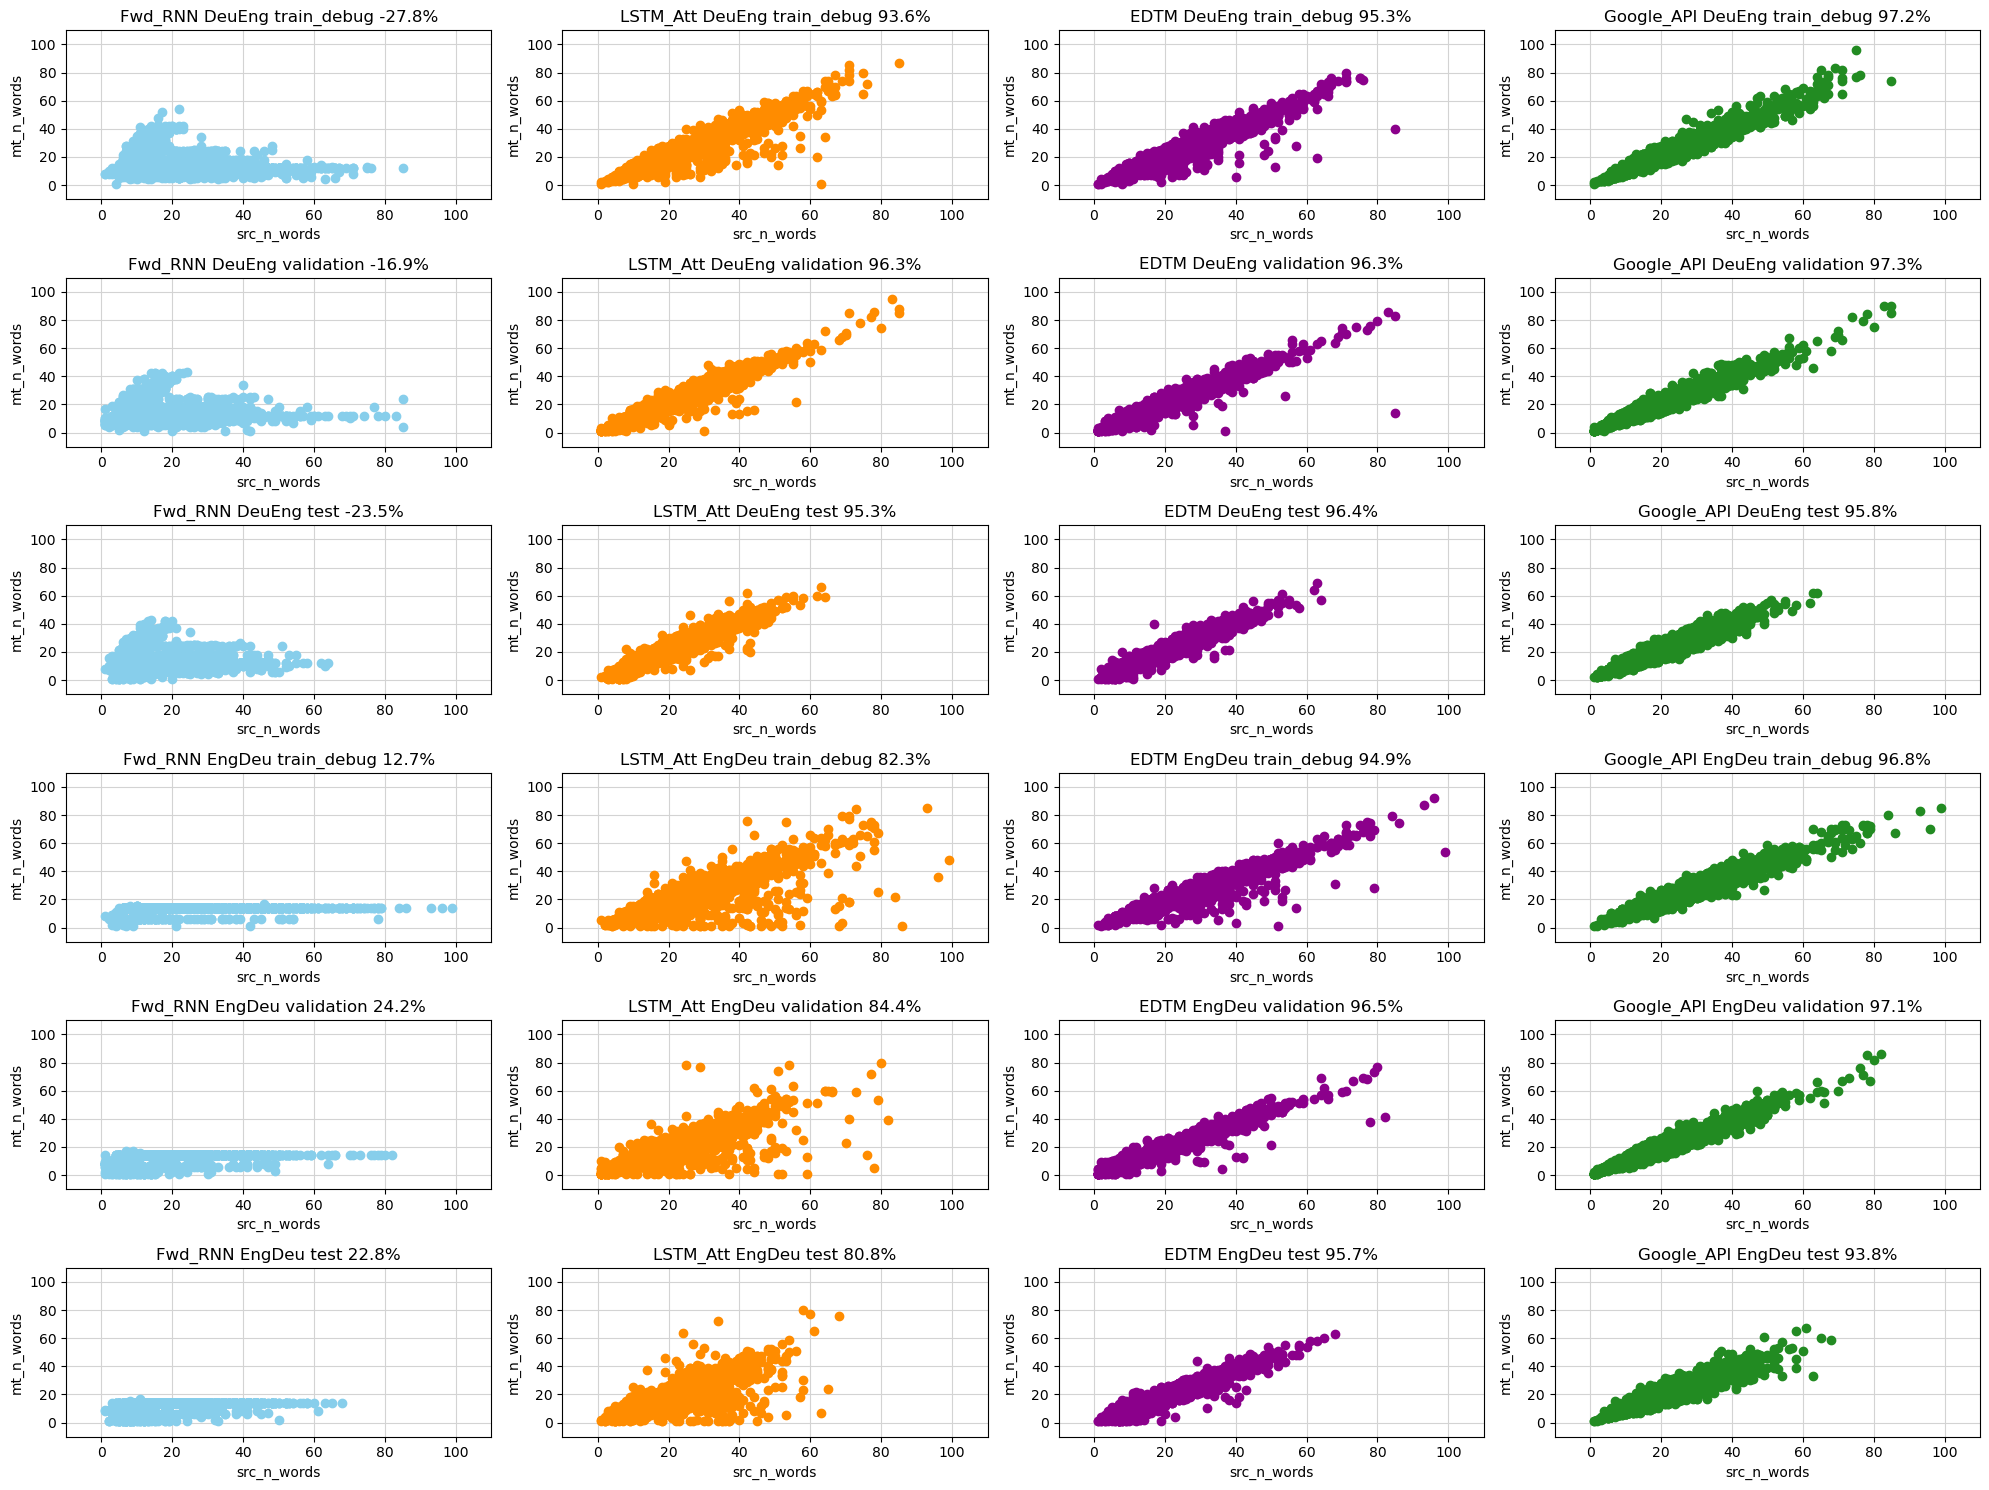

In [24]:
fig, axes = plt.subplots(6, 4, figsize=(20, 15))
axes = axes.reshape(-1)
model_colors = {"Fwd_RNN": "skyblue", "LSTM_Att": "darkorange", "EDTM": "darkmagenta", "Google_API": "forestgreen"}

i = 0
for lang_pair in ["DeuEng", "EngDeu"]:
    for data_set_name in ["train_debug", "validation", "test"]:
        for model_name in all_models.MODELS:
            mt_df = pd.read_csv(f"model_pred/{lang_pair}/{model_name}/{data_set_name}.csv")
            ax = axes[i]
            # Count words by counting the number of spaces, add 1 since there are (n-1) spaces between n words
            plot_df = pd.DataFrame({"src_n_words": mt_df["src"].str.count(" ") + 1, "mt_n_words": mt_df["mt"].str.count(" ") + 1})
            ax.scatter(plot_df["src_n_words"], plot_df["mt_n_words"], zorder=3, color=model_colors[model_name])
            ax.set_title(f"{model_name} {lang_pair} {data_set_name} {plot_df.corr().iloc[0, 1]:.1%}")
            ax.set_xlabel("src_n_words");ax.set_ylabel("mt_n_words")
            ax.set_xlim(-10, 110);ax.set_ylim(-10, 110)
            ax.grid(color="lightgray", zorder=-3)
            i += 1

plt.tight_layout();plt.show()

Seems like the EngDeu performance was harder for all the trained models. It appears that the Fwd_RNN was never able to predict anything beyond 20 words. This seems to be the result of it always producing the same answer for all translations.